In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from collections import defaultdict

import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

import itertools

import random

from skimage import measure
import dill
import csv


In [2]:
def read_image(path):
    return plt.imread(path)

(480, 640)


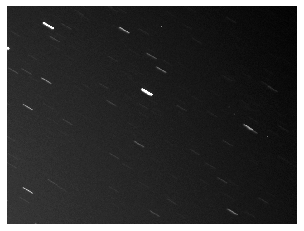

In [3]:
example_image=read_image('geoSatellites/train/1/1.png')
print(example_image.shape)
plt.imshow(example_image, cmap='gray')
plt.axis('off')
plt.show()

In [4]:
def read_annotation_file(path):
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict

train_annotation=read_annotation_file('geoSatellites/train_anno.json')

In [5]:
random.seed(0)

def random_different_coordinates(coords, size_x, size_y, pad):
    """ Returns a random set of coordinates that is different from the provided coordinates, 
    within the specified bounds.
    The pad parameter avoids coordinates near the bounds."""
    good = False
    while not good:
        good = True
        c1 = random.randint(pad + 1, size_x - (pad + 1))
        c2 = random.randint(pad + 1, size_y -( pad + 1))
        for c in coords:
            if c1 == c[0] and c2 == c[1]:
                good = False
                break
    return (c1,c2)

def extract_neighborhood(x, y, arr, radius):
    """ Returns a 1-d array of the values within a radius of the x,y coordinates given """
    return arr[(x - radius) : (x + radius + 1), (y - radius) : (y + radius + 1)].ravel()

def check_coordinate_validity(x, y, size_x, size_y, pad):
    """ Check if a coordinate is not too close to the image edge """
    return x >= pad and y >= pad and x + pad < size_x and y + pad < size_y

def generate_labeled_data(image_path, annotation, nb_false, radius):
    """ For one frame and one annotation array, returns a list of labels 
    (1 for true object and 0 for false) and the corresponding features as an array.
    nb_false controls the number of false samples
    radius defines the size of the sliding window (e.g. radius of 1 gives a 3x3 window)"""
    features,labels = [],[]
    im_array = read_image(image_path)
    # True samples
    for obj in annotation:
        obj = [int(x + .5) for x in obj] #Project the floating coordinate values onto integer pixel coordinates.
        # For some reason the order of coordinates is inverted in the annotation files
        if check_coordinate_validity(obj[1],obj[0],im_array.shape[0],im_array.shape[1],radius):
            features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            labels.append(1)
    # False samples
    for i in range(nb_false):
        c = random_different_coordinates(annotation,im_array.shape[1],im_array.shape[0],radius)
        features.append(extract_neighborhood(c[1],c[0],im_array,radius))
        labels.append(0)
    return np.array(labels),np.stack(features,axis=1)

In [6]:
def generate_labeled_set(annotation_array, path, sequence_id_list, radius, nb_false):
    # Generate labeled data for a list of sequences in a given path
    labels,features = [],[]
    for seq_id in sequence_id_list:
        for frame_id in range(1,6):
            d = generate_labeled_data(f"{path}{seq_id}/{frame_id}.png",
                                    annotation_array[seq_id][frame_id],
                                    nb_false,
                                    radius)
            labels.append(d[0])
            features.append(d[1])
    return np.concatenate(labels,axis=0), np.transpose(np.concatenate(features,axis=1))

In [7]:
radius=3
train_labels, train_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1,501), radius, 10)
print(train_labels.shape)
print(train_labels)
print(train_features.shape)

(29430,)
[1 1 1 ... 0 0 0]
(29430, 49)


In [8]:
import pandas as pd
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(501,550), radius, 500)
print(test_labels.shape)
print(test_labels)
print(test_features.shape)


(122924,)
[1 0 0 ... 0 0 0]
(122924, 49)


In [9]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In [10]:
%pip install xgboost
import xgboost
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
print(train_features.shape)
parameters = {
        'learning_rate': [0.01,0.1,1],
        'eta': [0.05, 0.15, 0.3],
        'max_depth': [4, 7, 10],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 2, 5],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.7, 0.9],
    }
xgb = XGBClassifier(
        verbose = 2,
        eval_metric = 'error',
        nthread = 1,
        silent = True,
        )

from sklearn.metrics import make_scorer, fbeta_score
f2_score = make_scorer(fbeta_score, beta=0.5, pos_label=1)
import time
start = time.time()
random_search = RandomizedSearchCV(xgb, param_distributions=parameters, n_iter=250, return_train_score=True,scoring='precision', n_jobs=1, cv=4, verbose=3, random_state=1001 )
#traindata = xgboost.DMatrix(train_features, label=train_labels)
#xgb = xgboost.train(params={},dtrain=traindata)
#dtest = xgboost.DMatrix(test_features)
random_search.fit(train_features,train_labels)
'''xg_labels = xgb.predict(dtest)
print(xg_labels)
xg_labels = np.round(xg_labels,0)
with open('geo_resultsxgrid.csv', 'a', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=' ')
    resultwriter.writerow( ['XGBOOST', 'RADIUS = '+str(radius)])
report = classification_report(xg_labels,test_labels,output_dict=True)
print(report)
df = pd.DataFrame(report).transpose()
df.to_csv('geo_resultsxgrid.csv',mode='a')
cf = confusion_matrix(xg_labels,test_labels)
print(cf)
df = pd.DataFrame(cf)
df.to_csv('geo_resultsxgrid.csv',mode='a')
print("Kappa =",cohen_kappa_score(xg_labels,test_labels))
with open('geo_resultsxgrid.csv', 'a', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=' ')
    resultwriter.writerow( ["Kappa = ",cohen_kappa_score(xg_labels,test_labels)])'''
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best score')
print(random_search.best_score_)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)
print(time.time()-start)

Note: you may need to restart the kernel to use updated packages.
(29430, 49)
Fitting 4 folds for each of 250 candidates, totalling 1000 fits
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[04:26:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.990, test=0.911), total=   7.7s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[04:26:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.991, test=0.905), total=   7.8s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[04:26:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s


[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.991, test=0.906), total=   8.0s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[04:26:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.991, test=0.927), total=   7.7s
[CV] subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=1, gamma=2, eta=0.15, colsample_bytree=0.9 
[04:26:35] WARNING: C:\Users\Administrator\workspace\xgboost

[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.9, score=(train=0.964, test=0.952), total=  15.9s
[CV] subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[04:30:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.999, test=0.954), total=  18.1s
[CV] subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[04:30:28] WARNING: C:\Users\Administrator\workspace

[CV]  subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.985, test=0.948), total=  20.3s
[CV] subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9 
[04:33:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.980, test=0.949), total=  20.4s
[CV] subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9 
[04:33:44] WARNING: C:\Users\Administrator\workspace\xg

[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9, score=(train=0.965, test=0.937), total=  21.1s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9 
[04:36:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9, score=(train=0.966, test=0.945), total=  21.2s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9 
[04:36:55] WARNING: C:\Users\Administrator\workspac

[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=0.979, test=0.961), total=   9.5s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9 
[04:39:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=0.976, test=0.961), total=   9.5s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.05, colsample_bytree=0.9 
[04:39:13] WARNING: C:\Users\Administrator\worksp

[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.9, score=(train=0.996, test=0.923), total=  21.3s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=2, eta=0.3, colsample_bytree=0.9 
[04:43:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=2, eta=0.3, colsample_bytree=0.9, score=(train=0.974, test=0.952), total=  19.5s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=2, eta=0.3, colsample_bytree=0.9 
[04:43:38] WARNING: C:\Users\Administrator\workspace\xgbo

[CV]  subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.985, test=0.911), total=  13.4s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7 
[04:46:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.988, test=0.917), total=  11.9s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7 
[04:46:29] WARNING: C:\Users\Administrator\workspace\xgboos

[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.999, test=0.921), total=   8.8s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[04:48:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.998, test=0.913), total=   8.8s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[04:49:06] WARNING: C:\Users\Administrator\workspace\xg

[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=0.991, test=0.913), total=   7.0s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=0.5, eta=0.05, colsample_bytree=0.9 
[04:51:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=0.991, test=0.929), total=   7.0s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.7 
[04:51:58] WARNING: C:\Users\Administrator\workspace\xgb

[CV]  subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.988, test=0.931), total=  13.2s
[CV] subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=5, eta=0.3, colsample_bytree=0.9 
[04:54:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.974, test=0.952), total=  11.9s
[CV] subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=5, eta=0.3, colsample_bytree=0.9 
[04:54:15] WARNING: C:\Users\Administrator\workspace\xgboost-wi

[CV]  subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.9, score=(train=0.995, test=0.950), total=  11.9s
[CV] subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.9 
[04:56:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.9, score=(train=0.996, test=0.949), total=  12.0s
[CV] subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.9 
[04:56:45] WARNING: C:\Users\Administrator\workspac

[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.971, test=0.946), total=  13.1s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[04:58:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.969, test=0.951), total=  13.1s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[04:58:57] WARNING: C:\Users\Administrator\work

[CV]  subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7, score=(train=0.997, test=0.928), total=  10.6s
[CV] subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7 
[05:01:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7, score=(train=0.997, test=0.930), total=  10.4s
[CV] subsample=0.7, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9 
[05:01:11] WARNING: C:\Users\Administrator\workspace\xgbo

[CV]  subsample=0.7, min_child_weight=1, max_depth=7, learning_rate=1, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=1.000, test=0.927), total=  11.8s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.01, gamma=2, eta=0.05, colsample_bytree=0.9 
[05:03:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.01, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.962, test=0.956), total=   7.3s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.01, gamma=2, eta=0.05, colsample_bytree=0.9 
[05:03:31] WARNING: C:\Users\Administrator\workspace\xgb

[CV]  subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=1.000, test=0.938), total=  12.5s
[CV] subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[05:05:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=1.000, test=0.929), total=  12.6s
[CV] subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[05:05:53] WARNING: C:\Users\Administrator\workspace\xg

[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.972, test=0.963), total=   5.8s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=5, eta=0.15, colsample_bytree=0.7 
[05:07:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.976, test=0.956), total=   5.9s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=5, eta=0.15, colsample_bytree=0.7 
[05:07:57] WARNING: C:\Users\Administrator\workspace\xgboos

[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=2, eta=0.15, colsample_bytree=0.7, score=(train=0.994, test=0.917), total=   8.7s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=2, eta=0.15, colsample_bytree=0.7 
[05:09:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=2, eta=0.15, colsample_bytree=0.7, score=(train=0.996, test=0.938), total=   8.5s
[CV] subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9 
[05:10:02] WARNING: C:\Users\Administrator\workspace\xgboost-win6

[CV]  subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=1, gamma=2, eta=0.15, colsample_bytree=0.7, score=(train=0.995, test=0.929), total=   5.7s
[CV] subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9 
[05:11:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9, score=(train=0.964, test=0.955), total=   7.2s
[CV] subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9 
[05:12:03] WARNING: C:\Users\Administrator\workspace\xgboo

[CV]  subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.976, test=0.950), total=  12.1s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[05:13:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.971, test=0.937), total=  12.1s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[05:14:01] WARNING: C:\Users\Administrator\work

[CV]  subsample=0.7, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.991, test=0.951), total=  10.5s
[CV] subsample=0.7, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[05:16:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.992, test=0.951), total=  10.4s
[CV] subsample=0.7, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[05:16:34] WARNING: C:\Users\Administrator\workspac

[CV]  subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=0.970, test=0.949), total=  11.6s
[CV] subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9 
[05:18:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=0.972, test=0.950), total=  11.7s
[CV] subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.7 
[05:18:46] WARNING: C:\Users\Administrator\workspa

[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.979, test=0.963), total=   5.9s
[CV] subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.7 
[05:20:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.7, score=(train=0.976, test=0.957), total=  14.7s
[CV] subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.7 
[05:20:31] WARNING: C:\Users\Administrator\workspace\xgb

[CV]  subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=0.973, test=0.953), total=   7.3s
[CV] subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9 
[05:22:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=0.971, test=0.952), total=   6.9s
[CV] subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.05, colsample_bytree=0.9 
[05:22:51] WARNING: C:\Users\Administrator\workspac

[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.964, test=0.953), total=   6.0s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[05:24:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.966, test=0.957), total=   6.1s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[05:24:31] WARNING: C:\Users\Administrator\workspac

[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.968, test=0.948), total=  15.8s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, eta=0.05, colsample_bytree=0.9 
[05:26:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.968, test=0.946), total=  15.7s
[CV] subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7 
[05:26:51] WARNING: C:\Users\Administrator\workspace\

[CV]  subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.974, test=0.963), total=   5.8s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7 
[05:28:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.980, test=0.926), total=   5.6s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7 
[05:28:29] WARNING: C:\Users\Administrator\workspace\xgboost

[CV]  subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.05, colsample_bytree=0.7, score=(train=0.995, test=0.961), total=  14.3s
[CV] subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.05, colsample_bytree=0.7 
[05:30:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.05, colsample_bytree=0.7, score=(train=0.995, test=0.949), total=  14.5s
[CV] subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.05, colsample_bytree=0.7 
[05:30:27] WARNING: C:\Users\Administrator\

[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.970, test=0.959), total=   6.0s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=5, eta=0.05, colsample_bytree=0.7 
[05:32:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.969, test=0.954), total=   6.0s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=5, eta=0.05, colsample_bytree=0.7 
[05:32:48] WARNING: C:\Users\Administrator\workspace\xgboos

[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.982, test=0.922), total=   7.0s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9 
[05:34:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.985, test=0.926), total=   7.0s
[CV] subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=1, gamma=0.5, eta=0.3, colsample_bytree=0.9 
[05:34:16] WARNING: C:\Users\Administrator\workspace\xgboost-win

[CV]  subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=5, eta=0.15, colsample_bytree=0.9, score=(train=0.975, test=0.949), total=  11.7s
[CV] subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.7 
[05:36:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.7, score=(train=0.997, test=0.924), total=  10.3s
[CV] subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.7 
[05:36:49] WARNING: C:\Users\Administrator\workspace\xgboost-win6

[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.9, score=(train=0.998, test=0.926), total=  10.5s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.9 
[05:38:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.9, score=(train=0.999, test=0.917), total=  10.4s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.9 
[05:38:51] WARNING: C:\Users\Administrator\workspace\xg

[CV]  subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.974, test=0.936), total=  12.1s
[CV] subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[05:40:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.974, test=0.947), total=  12.3s
[CV] subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[05:41:09] WARNING: C:\Users\Administrator\work

[CV]  subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.7, score=(train=0.987, test=0.903), total=   9.1s
[CV] subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.7 
[05:43:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.7, score=(train=0.989, test=0.926), total=   9.1s
[CV] subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=0.01, gamma=2, eta=0.15, colsample_bytree=0.7 
[05:43:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64

[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.994, test=0.952), total=  17.1s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9 
[05:45:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.968, test=0.955), total=   7.1s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9 
[05:45:31] WARNING: C:\Users\Administrator\workspace\xg

[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.9, score=(train=0.984, test=0.934), total=  10.8s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.9 
[05:47:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.9, score=(train=0.980, test=0.901), total=  10.8s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.9 
[05:47:27] WARNING: C:\Users\Administrator\workspace\xgboost-wi

[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.988, test=0.911), total=   5.7s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7 
[05:49:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.988, test=0.915), total=   5.8s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7 
[05:49:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_

[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.968, test=0.953), total=   7.2s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9 
[05:51:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.969, test=0.957), total=   7.2s
[CV] subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[05:51:55] WARNING: C:\Users\Administrator\workspace\xgb

[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=2, eta=0.3, colsample_bytree=0.7, score=(train=0.995, test=0.947), total=  13.8s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7 
[05:53:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7, score=(train=0.995, test=0.916), total=   8.6s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7 
[05:54:05] WARNING: C:\Users\Administrator\workspace\xgboost-w

[CV]  subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.984, test=0.927), total=  10.5s
[CV] subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9 
[05:56:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.984, test=0.911), total=  10.5s
[CV] subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9 
[05:56:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_

[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.964, test=0.950), total=   5.9s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[05:58:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.965, test=0.951), total=   5.8s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[05:58:38] WARNING: C:\Users\Administrator\

[CV]  subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.976, test=0.950), total=   9.4s
[CV] subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=5, eta=0.05, colsample_bytree=0.7 
[06:00:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.979, test=0.957), total=   9.4s
[CV] subsample=0.9, min_child_weight=5, max_depth=4, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.9 
[06:00:28] WARNING: C:\Users\Administrator\workspace\xgbo

[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=1, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.999, test=0.915), total=   6.9s
[CV] subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=5, eta=0.15, colsample_bytree=0.9 
[06:01:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=5, eta=0.15, colsample_bytree=0.9, score=(train=0.976, test=0.946), total=  11.6s
[CV] subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=5, eta=0.15, colsample_bytree=0.9 
[06:02:06] WARNING: C:\Users\Administrator\workspace\xgboost-

[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.981, test=0.922), total=   6.1s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7 
[06:04:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.979, test=0.901), total=   5.9s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7 
[06:04:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_

[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9, score=(train=0.965, test=0.946), total=   7.1s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9 
[06:06:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9, score=(train=0.963, test=0.947), total=   7.2s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9 
[06:06:54] WARNING: C:\Users\Administrator\workspace\xg

[CV]  subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.962, test=0.946), total=  15.8s
[CV] subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.9 
[06:09:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.966, test=0.952), total=  15.5s
[CV] subsample=0.7, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.9 
[06:09:45] WARNING: C:\Users\Administrator\workspace\x

[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.985, test=0.922), total=   7.4s
[CV] subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.9 
[06:11:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.9, score=(train=0.980, test=0.946), total=  15.2s
[CV] subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.9 
[06:11:40] WARNING: C:\Users\Administrator\workspace\

[CV]  subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.988, test=0.924), total=   9.0s
[CV] subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7 
[06:13:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.987, test=0.900), total=   9.1s
[CV] subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7 
[06:13:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_

[CV]  subsample=0.7, min_child_weight=10, max_depth=4, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.9, score=(train=0.980, test=0.892), total=   7.1s
[CV] subsample=0.7, min_child_weight=10, max_depth=4, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.9 
[06:15:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=10, max_depth=4, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.9, score=(train=0.985, test=0.916), total=   7.1s
[CV] subsample=0.7, min_child_weight=10, max_depth=4, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.9 
[06:15:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_

[CV]  subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=1, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.994, test=0.914), total=  10.6s
[CV] subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=1, gamma=2, eta=0.15, colsample_bytree=0.9 
[06:17:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=1, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.995, test=0.930), total=  10.5s
[CV] subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=1, gamma=2, eta=0.15, colsample_bytree=0.9 
[06:17:54] WARNING: C:\Users\Administrator\workspace\xgboost-win

[CV]  subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.9, score=(train=0.984, test=0.958), total=  11.6s
[CV] subsample=0.7, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9 
[06:20:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.977, test=0.957), total=   7.2s
[CV] subsample=0.7, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9 
[06:20:15] WARNING: C:\Users\Administrator\workspace\xgbo

[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.987, test=0.950), total=  15.3s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9 
[06:21:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.985, test=0.953), total=  15.5s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9 
[06:22:11] WARNING: C:\Users\Administrator\workspace\xg

[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.7, score=(train=0.985, test=0.947), total=  12.6s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.7 
[06:25:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.7, score=(train=0.986, test=0.952), total=  12.7s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.7 
[06:25:21] WARNING: C:\Users\Administrator\workspace\xg

[CV]  subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.961, test=0.946), total=  12.5s
[CV] subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.7 
[06:27:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.965, test=0.951), total=  12.5s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=1, gamma=0.5, eta=0.3, colsample_bytree=0.9 
[06:27:18] WARNING: C:\Users\Administrator\workspa

[CV]  subsample=0.7, min_child_weight=1, max_depth=4, learning_rate=0.01, gamma=2, eta=0.15, colsample_bytree=0.7, score=(train=0.963, test=0.950), total=   6.1s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9 
[06:29:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9, score=(train=0.961, test=0.951), total=  11.9s
[CV] subsample=0.9, min_child_weight=10, max_depth=7, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.9 
[06:29:27] WARNING: C:\Users\Administrator\workspace

[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.9, score=(train=0.992, test=0.916), total=   7.1s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.9 
[06:31:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.9, score=(train=0.994, test=0.910), total=   7.1s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=2, eta=0.3, colsample_bytree=0.9 
[06:31:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_rele

[CV]  subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.971, test=0.933), total=  14.8s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9 
[06:33:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.970, test=0.949), total=  15.1s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=2, eta=0.05, colsample_bytree=0.9 
[06:33:53] WARNING: C:\Users\Administrator\workspac

[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.7, score=(train=0.964, test=0.950), total=   5.9s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.7 
[06:35:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.7, score=(train=0.962, test=0.951), total=   5.8s
[CV] subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=1, gamma=5, eta=0.3, colsample_bytree=0.9 
[06:35:25] WARNING: C:\Users\Administrator\workspace\xgboos

[CV]  subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=1, gamma=0.5, eta=0.05, colsample_bytree=0.7, score=(train=1.000, test=0.935), total=   9.3s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7 
[06:37:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.980, test=0.926), total=   5.8s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7 
[06:37:23] WARNING: C:\Users\Administrator\workspace\xgboost-w

[CV]  subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.991, test=0.914), total=  11.3s
[CV] subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7 
[06:38:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7, score=(train=0.991, test=0.891), total=  11.3s
[CV] subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=1, gamma=5, eta=0.05, colsample_bytree=0.7 
[06:39:06] WARNING: C:\Users\Administrator\workspace\xgboost-wi

[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.966, test=0.947), total=   7.1s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.9 
[06:41:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.963, test=0.950), total=   7.2s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=5, eta=0.3, colsample_bytree=0.9 
[06:41:19] WARNING: C:\Users\Administrator\workspace\xg

[CV]  subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=0.01, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=0.964, test=0.953), total=  12.3s
[CV] subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=0.01, gamma=0.5, eta=0.05, colsample_bytree=0.9 
[06:43:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=0.01, gamma=0.5, eta=0.05, colsample_bytree=0.9, score=(train=0.967, test=0.956), total=  12.2s
[CV] subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=0.1, gamma=2, eta=0.3, colsample_bytree=0.9 
[06:43:48] WARNING: C:\Users\Administrator\workspac

[CV]  subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.9, score=(train=1.000, test=0.925), total=  10.8s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[06:45:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.972, test=0.958), total=   5.8s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[06:45:56] WARNING: C:\Users\Administrator\workspa

[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.982, test=0.949), total=  15.5s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=5, eta=0.3, colsample_bytree=0.9 
[06:48:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=5, eta=0.3, colsample_bytree=0.9, score=(train=0.981, test=0.954), total=  15.5s
[CV] subsample=0.9, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=5, eta=0.3, colsample_bytree=0.9 
[06:48:31] WARNING: C:\Users\Administrator\workspace\xgboos

[CV]  subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.963, test=0.936), total=  12.9s
[CV] subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.7 
[06:50:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.964, test=0.949), total=  13.3s
[CV] subsample=0.7, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=5, eta=0.15, colsample_bytree=0.7 
[06:51:06] WARNING: C:\Users\Administrator\workspac

[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=1.000, test=0.931), total=  11.9s
[CV] subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[06:53:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=1.000, test=0.935), total=  11.8s
[CV] subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9 
[06:53:55] WARNING: C:\Users\Administrator\workspace\xgb

[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=0.5, eta=0.3, colsample_bytree=0.9, score=(train=0.999, test=0.944), total=  16.9s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.9 
[06:56:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.9, score=(train=0.996, test=0.918), total=  11.8s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.9 
[06:56:58] WARNING: C:\Users\Administrator\workspace\xgbo

[CV]  subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.998, test=0.925), total=   8.8s
[CV] subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[06:58:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7, score=(train=0.998, test=0.899), total=   8.8s
[CV] subsample=0.7, min_child_weight=5, max_depth=7, learning_rate=1, gamma=0.5, eta=0.15, colsample_bytree=0.7 
[06:58:52] WARNING: C:\Users\Administrator\workspace\xgboos

[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.966, test=0.944), total=   7.1s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=2, eta=0.15, colsample_bytree=0.9 
[07:00:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.963, test=0.947), total=   7.1s
[CV] subsample=0.9, min_child_weight=10, max_depth=4, learning_rate=0.01, gamma=2, eta=0.15, colsample_bytree=0.9 
[07:00:34] WARNING: C:\Users\Administrator\workspac

[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.997, test=0.946), total=  16.9s
[CV] subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9 
[07:02:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.994, test=0.952), total=  16.9s
[CV] subsample=0.7, min_child_weight=10, max_depth=10, learning_rate=0.1, gamma=5, eta=0.15, colsample_bytree=0.7 
[07:03:16] WARNING: C:\Users\Administrator\workspace\x

[CV]  subsample=0.9, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=2, eta=0.15, colsample_bytree=0.9, score=(train=0.998, test=0.953), total=  16.6s
[CV] subsample=0.7, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.9 
[07:05:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.9, score=(train=0.977, test=0.957), total=  12.7s
[CV] subsample=0.7, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.9 
[07:05:51] WARNING: C:\Users\Administrator\workspace\xgboo

[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.988, test=0.961), total=  14.7s
[CV] subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[07:08:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7, score=(train=0.991, test=0.959), total=  14.7s
[CV] subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.7 
[07:08:27] WARNING: C:\Users\Administrator\work

[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.988, test=0.911), total=   5.7s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7 
[07:10:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7, score=(train=0.988, test=0.915), total=   5.8s
[CV] subsample=0.9, min_child_weight=1, max_depth=4, learning_rate=1, gamma=5, eta=0.15, colsample_bytree=0.7 
[07:10:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_

[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.9, score=(train=0.989, test=0.953), total=  18.1s
[CV] subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.9 
[07:12:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=1, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.9, score=(train=0.988, test=0.953), total=  17.6s
[CV] subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.9 
[07:13:11] WARNING: C:\Users\Administrator\workspa

[CV]  subsample=0.9, min_child_weight=10, max_depth=10, learning_rate=0.01, gamma=0.5, eta=0.3, colsample_bytree=0.9, score=(train=0.963, test=0.946), total=  15.1s
[CV] subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=0.01, gamma=5, eta=0.05, colsample_bytree=0.9 
[07:15:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=0.01, gamma=5, eta=0.05, colsample_bytree=0.9, score=(train=0.957, test=0.953), total=  11.9s
[CV] subsample=0.7, min_child_weight=10, max_depth=7, learning_rate=0.01, gamma=5, eta=0.05, colsample_bytree=0.9 
[07:16:09] WARNING: C:\Users\Administrator\worksp

[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7, score=(train=0.992, test=0.907), total=   5.9s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7 
[07:17:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7, score=(train=0.990, test=0.919), total=   6.0s
[CV] subsample=0.7, min_child_weight=5, max_depth=4, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7 
[07:18:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_

[CV]  subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.01, gamma=0.5, eta=0.15, colsample_bytree=0.9, score=(train=0.967, test=0.940), total=  12.1s
[CV] subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.01, gamma=0.5, eta=0.15, colsample_bytree=0.9 
[07:20:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.01, gamma=0.5, eta=0.15, colsample_bytree=0.9, score=(train=0.970, test=0.953), total=  11.9s
[CV] subsample=0.9, min_child_weight=5, max_depth=7, learning_rate=0.01, gamma=0.5, eta=0.15, colsample_bytree=0.9 
[07:20:18] WARNING: C:\Users\Administrator\work

[CV]  subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.7, score=(train=0.983, test=0.955), total=  10.0s
[CV] subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.7 
[07:22:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=2, eta=0.3, colsample_bytree=0.7, score=(train=0.985, test=0.962), total=  10.0s
[CV] subsample=0.7, min_child_weight=1, max_depth=4, learning_rate=1, gamma=2, eta=0.05, colsample_bytree=0.7 
[07:22:49] WARNING: C:\Users\Administrator\workspace\xgboost-

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 177.6min finished


[07:23:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 All results:
{'mean_fit_time': array([ 7.76377529, 20.77636385, 16.05339617, 15.92821389, 18.03092647,
       12.52967286, 11.91288066, 20.42452896,  7.82084608, 13.04673117,
       21.05276811,  9.54346418,  9.30331308,  9.50581974, 21.55076605,
       17.95785463, 20.89262974, 19.8115955 ,  8.33481991, 12.40791637,
       11.26183796, 15.41293758, 11.42613339,  8.63545048, 17.78958333,
       15.50928569,  6.92778075,  6.07048118, 11.27444756, 13.43032461,
       11.7756691 ,  9.27885664, 12.62195927, 11.95035577,  7.02769744,
        9.49771017, 13.01153076, 12.18405259,  7.03347063, 10.36125046

In [11]:
def classify_image(im, model, radius):
    n_features=(2*radius+1)**2 #Total number of pixels in the neighborhood
    feat_array=np.zeros((im.shape[0],im.shape[1],n_features))
    for x in range(radius+1,im.shape[0]-(radius+1)):
        for y in range(radius+1,im.shape[1]-(radius+1)):
            feat_array[x,y,:]=extract_neighborhood(x,y,im,radius)
    all_pixels=feat_array.reshape(im.shape[0]*im.shape[1],n_features)
    pred_pixels=model.predict(all_pixels).astype(np.bool_)
    pred_image=pred_pixels.reshape(im.shape[0],im.shape[1])
    return pred_image
def extract_centroids(pred, bg):
    conn_comp=measure.label(pred, background=bg)
    object_dict=defaultdict(list) #Keys are the indices of the connected components and values are arrrays of their pixel coordinates 
    for (x,y),label in np.ndenumerate(conn_comp):
            if label != bg:
                object_dict[label].append([x,y])
    # Mean coordinate vector for each object, except the "0" label which is the background
    centroids={label: np.mean(np.stack(coords),axis=0) for label,coords in object_dict.items()}
    object_sizes={label: len(coords) for label,coords in object_dict.items()}
    return centroids, object_sizes
def filter_large_objects(centroids,object_sizes, max_size):
    small_centroids={}
    for label,coords in centroids.items():
            if object_sizes[label] <= max_size:
                small_centroids[label]=coords
    return small_centroids

def predict_objects(sequence_id, frame_id, model, radius, max_size):
    print(sequence_id)
    test_image = plt.imread(f"geoSatellites/train/{sequence_id}/{frame_id}.png")
    test_pred=classify_image(test_image, model, radius)
    test_centroids, test_sizes = extract_centroids(test_pred, 0)
    test_centroids = filter_large_objects(test_centroids, test_sizes, max_size)
    # Switch x and y coordinates for submission
    if len(test_centroids.values()) > 0:
        sub=np.concatenate([c[np.array([1,0])].reshape((1,2)) for c in test_centroids.values()])
        #np array converted to list for json seralization, truncated to the first 30 elements
        return sub.tolist()[0:30]
    else:
        return []

'''import time
start_time = time.time()

#test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(501,550), radius, 500)
#myframe = 1
from multiprocessing import Pool
sequencerange = range(1201,1281)
framerange = range(1,6)
sub_list = []
for myseq in sequencerange:
    for myframe in framerange:
        sub_list.append(predict_objects(myseq,myframe,RF,radius,1))
        #print(len(sub_list))
        #print(sub_list[0:5])
nb_procs = 2
#p = Pool(processes=nb_procs)
submission=[]
for s in range(1201,1281):
    #print(s)
    for fr in range(1,6):
        if s in sequencerange:
            submission.append({"sequence_id" : s, 
                                    "frame" : fr, 
                                    "num_objects" : len(sub_list[(s-1201)*5 + fr-1]), 
                                    "object_coords" : sub_list[(s-1201)*5 + fr-1]})
        else:
            submission.append({"sequence_id" : s,
                                    "frame" : fr,
                                    "num_objects" : 0,
                                    "object_coords" : []})
with open('my_submissionSmall_nothread_rad3_neg20_RF_train1201-1280.json', 'w') as outfile:
    json.dump(submission, outfile)'''
'''sequence_list, frame_list = np.arange(1, 5121), np.arange(1, 6)
id_pair_list = list(itertools.product(sequence_list, frame_list))
sub_sequence = p.starmap(predict_objects, [(id_pair[0], id_pair[1], svc, radius, 1) for id_pair in id_pair_list])
p.close()
sub_dict = {id_pair: sub for id_pair,sub in zip(id_pair_list, sub_sequence)}

submission=[]
for id_pair,sub_list in sub_dict.items():
            submission.append({"sequence_id" : int(id_pair[0]), 
                                    "frame" : int(id_pair[1]), 
                                    "num_objects" : len(sub_list), 
                                    "object_coords" : sub_list})
with open('my_submissionSmall.json', 'w') as outfile:
    json.dump(submission, outfile)'''
'''for myseq in range(800,811):
    for myframe in range(1,6):
        sub_list=predict_objects(myseq,myframe,svc,radius,1)
        print(len(sub_list))
        print(sub_list[0:5])
'''
#print("--- %s seconds ---" % (time.time() - start_time))

'for myseq in range(800,811):\n    for myframe in range(1,6):\n        sub_list=predict_objects(myseq,myframe,svc,radius,1)\n        print(len(sub_list))\n        print(sub_list[0:5])\n'

In [14]:
traindata = xgboost.DMatrix(train_features, label=train_labels)
xgbClf = xgboost.train(params={'subsample': 0.9, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 2, 'eta': 0.05, 'colsample_bytree': 0.7},dtrain=traindata)
dtest = xgboost.DMatrix(test_features)
xg_labels = xgbClf.predict(dtest)
print(xg_labels)
xg_labels = np.round(xg_labels,0)
with open('geo_resultsxgrid.csv', 'a', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=' ')
    resultwriter.writerow( ['XGBOOST no params', 'RADIUS = '+str(radius)])
report = classification_report(xg_labels,test_labels,output_dict=True)
print(report)
df = pd.DataFrame(report).transpose()
df.to_csv('geo_resultsxgrid.csv',mode='a')
cf = confusion_matrix(xg_labels,test_labels)
print(cf)
df = pd.DataFrame(cf)
df.to_csv('geo_resultsxgrid.csv',mode='a')
print("Kappa =",cohen_kappa_score(xg_labels,test_labels))
with open('geo_resultsxgrid.csv', 'a', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=' ')
    resultwriter.writerow( ["Kappa = ",cohen_kappa_score(xg_labels,test_labels)])

[0.58488715 0.21258438 0.315495   ... 0.21189293 0.23139995 0.2456584 ]
{'0.0': {'precision': 0.9959183673469387, 'recall': 0.9978978708785591, 'f1-score': 0.9969071364659642, 'support': 122257}, '1.0': {'precision': 0.3938679245283019, 'recall': 0.25037481259370314, 'f1-score': 0.30614115490375804, 'support': 667}, 'accuracy': 0.9938417233412515, 'macro avg': {'precision': 0.6948931459376203, 'recall': 0.6241363417361311, 'f1-score': 0.6515241456848611, 'support': 122924}, 'weighted avg': {'precision': 0.9926515712342184, 'recall': 0.9938417233412515, 'f1-score': 0.9931589594647113, 'support': 122924}}
[[122000    257]
 [   500    167]]
Kappa = 0.30320237600557143
